In [1]:
!pip install keras-tcn

Looking in indexes: http://mirrors.tencentyun.com/pypi/simple
     |████████████████████████████████| 377 kB 871 kB/s eta 0:00:01


In [2]:
import numpy
from matplotlib import pyplot
from pandas import read_csv
import math
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [3]:
# load the dataset
dataframe = read_csv('intecleaned-correct.csv',usecols=[1,2,4,5,6,7,8,9])
dataset = dataframe.values
#将整型变为float
dataset = dataset.astype('float32')
dataframe.head()

,短期预测功率,短期预测湿度,短期预测风向,短期预测温度,短期预测气压,实际功率,实际风速,短期预测风速
0,34.41,75,41,14.7,1008,28.59,8.50,8.864167
1,33.71,75,40,14.7,1008,29.80,8.75,8.764167
2,33.01,75,39,14.6,1008,23.80,7.78,8.664167
3,32.32,75,38,14.5,1008,23.63,7.89,8.564167
4,31.66,75,38,14.5,1008,26.98,7.69,8.464167


In [4]:
def create_dataset(dataset, look_back,look_lag,data_step):
    main_dataX, main_dataY ,auxi_dataX,auxi_dataY= [], [],[],[]
    for i in range(0,len(dataset)-look_back-look_lag+1,data_step):
        a = dataset[i:(i+look_back), 1:8] #前一天的短期预测湿度、短期预测风向、短期预测温度、
                                        #短期预测气压、实际功率、实际风速都作为输入特征（共7个）
        c = dataset[(i+look_back):(i+look_back+look_lag),1:5]#当天的短期预测功率、短期预测湿度、短期预测风向、短期预测温度、短期预测气压作为特征（共4个）
        d = dataset[(i+look_back):(i+look_back+look_lag),7:8]#当天短期预测风速作为特征（共1个）
        e = numpy.hstack([a,c])
        e = numpy.hstack([d,e])#把上面的特征都合在一起，共12个特征
        main_dataX.append(e) #主要输入
        b = dataset[(i+look_back):(i+look_back+look_lag),5]
        main_dataY.append(b) #主要输出 需要预测的功率数据
    return numpy.array(main_dataX), numpy.array(main_dataY)#,numpy.array(auxi_dataX),numpy.array(auxi_dataY)

In [5]:
# fix random seed for reproducibility
numpy.random.seed(7)
# normalize the dataset
scaler_y = MinMaxScaler(feature_range=(0, 1))#功率数据归一化，之后还原预测结果要用
Y = scaler_y.fit_transform(dataset[:,5:6])

scaler_y1 = MinMaxScaler(feature_range=(0, 1))#风速数据归一化
Y1 = scaler_y1.fit_transform(dataset[:,6:7])

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [6]:
look_back = 16
look_lag = 16
train_size = 364*96
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size-look_back:len(dataset),:]
train_mainX, train_mainY = create_dataset(train, look_back,look_lag,4)#,train_auxiX,train_auxiY
test_mainX, test_mainY = create_dataset(test, look_back,look_lag,16)#,test_auxiX,test_auxiY

# reshape input to be [samples, time steps, features]
train_mainX = numpy.reshape(train_mainX, (train_mainX.shape[0], look_back, 12))

test_mainX = numpy.reshape(test_mainX, (test_mainX.shape[0], look_back, 12))

In [8]:
from tensorflow.keras.layers import Dense,Dropout,LSTM,concatenate
from tensorflow.keras import Input, Model
from tcn import TCN,tcn_full_summary
from tensorflow.keras.regularizers import l2
#输入层
Input = Input(batch_shape=(None,train_mainX.shape[1],train_mainX.shape[2]))
TCN1 = TCN(nb_filters=128, kernel_size=3, activation='relu', padding='same',return_sequences=False)(Input)

output = Dense(units = look_lag)(TCN1)#主要输出
#main_output = Dropout(0.2)(main_output)

model = Model(inputs=Input, outputs=output)
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(train_mainX,train_mainY, validation_split=0.33,epochs=100,shuffle=True)

Train on 5848 samples, validate on 2881 samples
Epoch 1/100
5848/5848 [==============================] - 4s 691us/sample - loss: 0.2773 - val_loss: 0.0264
Epoch 2/100
5848/5848 [==============================] - 2s 307us/sample - loss: 0.0203 - val_loss: 0.0206
Epoch 3/100
5848/5848 [==============================] - 2s 298us/sample - loss: 0.0177 - val_loss: 0.0217
Epoch 4/100
5848/5848 [==============================] - 2s 286us/sample - loss: 0.0167 - val_loss: 0.0219
Epoch 5/100
5848/5848 [==============================] - 2s 300us/sample - loss: 0.0164 - val_loss: 0.0193
Epoch 6/100
5848/5848 [==============================] - 2s 296us/sample - loss: 0.0146 - val_loss: 0.0156
Epoch 7/100
5848/5848 [==============================] - 2s 295us/sample - loss: 0.0148 - val_loss: 0.0186
Epoch 8/100
5848/5848 [==============================] - 2s 301us/sample - loss: 0.0134 - val_loss: 0.0154
Epoch 9/100
5848/5848 [==============================] - 2s 297us/sample - loss: 0.0133 - val_lo

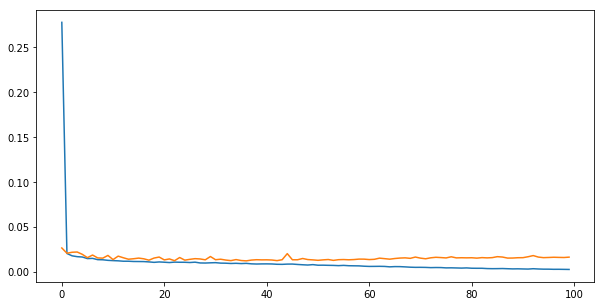

In [9]:
pyplot.figure(figsize=(10,5))
pyplot.plot(history.history['loss'], label='loss')
pyplot.plot(history.history['val_loss'], label='val_loss')

In [10]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16, 12)]          0         
_________________________________________________________________
tcn_1 (TCN)                  (None, 128)               548480    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
Total params: 550,544
Trainable params: 550,544
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 执行预测
testPredict = model.predict(test_mainX)

In [12]:
testPredict.shape

(540, 16)

In [13]:
testPredict = testPredict.reshape(-1,1)
testPredict = scaler_y.inverse_transform(testPredict)

In [14]:
testPredict

array([[32.13633 ],
       [33.151875],
       [33.618534],
       ...,
       [19.009844],
       [21.011484],
       [21.133669]], dtype=float32)

In [15]:
test_mainY = test_mainY.reshape(-1,1)
test_mainY = scaler_y.inverse_transform(test_mainY)
test_mainY.shape

(8640, 1)

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
def result(testY,testPredict):
    mse = mean_squared_error(testY,testPredict)
    mae = mean_absolute_error(testY,testPredict)
    r_square = r2_score(testY,testPredict)
    print("MSE:",mse)
    print("MAE:",mae)
    print("R_Square:",r_square)
    rmse = math.sqrt(mse)
    print("RMSE:",rmse)
    capacity = 49.5
    print("NRMSE:",1 - rmse/capacity)
    p_hme = 0
    whole_power = 49.5
    for l in range(testY.shape[0]):
        if testY[l] <= whole_power * 0.03 and testPredict[l] <= whole_power * 0.03:
            continue
        p_hme = p_hme + abs(testY[l] / (testY[l] + testPredict[l]) - 0.5) * abs(testPredict[l] -testY[l]) / np.sum(np.abs(testPredict - testY))
    p_hme =  1 - 2 * p_hme
    print('E', p_hme)

In [17]:
predictions_1 = testPredict[0:31*96,0]
predictions_2 = testPredict[31*96:59*96,0]
predictions_3 = testPredict[59*96:90*96,0]

test_labels_1 = test_mainY[0:31*96,0]
test_labels_2 = test_mainY[31*96:59*96,0]
test_labels_3 = test_mainY[59*96:90*96,0]

print("2019年1-3月结果：")
result(test_mainY,testPredict)
print("2019年1月结果：")
result(test_labels_1,predictions_1)
print("2019年2月结果：")
result(test_labels_2,predictions_2)
print("2019年3月结果：")
result(test_labels_3,predictions_3)

2019年1-3月结果：
MSE: 40.785225
MAE: 4.4254365
R_Square: 0.7760217007232391
RMSE: 6.386331099665189
NRMSE: 0.8709832101077739
E [0.691443]
2019年1月结果：
MSE: 38.13912
MAE: 4.4547253
R_Square: 0.7672471962846911
RMSE: 6.175687669772499
NRMSE: 0.8752386329338889
E 0.7328041745250038
2019年2月结果：
MSE: 45.28443
MAE: 4.6224103
R_Square: 0.7575231586399942
RMSE: 6.729370806956585
NRMSE: 0.864053115010978
E 0.6878557959849058
2019年3月结果：
MSE: 39.367527
MAE: 4.218235
R_Square: 0.7885910737703132
RMSE: 6.274354708498448
NRMSE: 0.8732453594242737
E 0.6513132968353261


In [18]:
#原系统准确率
testorin=dataframe.values[train_size:,0]
testorin=testorin.reshape(8640,1)
systempredictions_1 = testorin[0:31*96,0]
systempredictions_2 = testorin[31*96:59*96,0]
systempredictions_3 = testorin[59*96:90*96,0]
#原始系统准确率
print("原始系统准确率:")
print("2019年1-3月结果：")
result(test_mainY,testorin)
print("2019年1月结果：")
result(test_labels_1,systempredictions_1)
print("2019年2月结果：")
result(test_labels_2,systempredictions_2)
print("2019年3月结果：")
result(test_labels_3,systempredictions_3)

原始系统准确率:
2019年1-3月结果：
MSE: 38.90323077467954
MAE: 4.73843288221362
R_Square: 0.7863569507222773
RMSE: 6.237245447685985
NRMSE: 0.8739950414608892
E [0.66917906]
2019年1月结果：
MSE: 38.48454371279563
MAE: 4.870769504471107
R_Square: 0.7651391491589099
RMSE: 6.203591194847999
NRMSE: 0.8746749253566061
E 0.7053141024294813
2019年2月结果：
MSE: 43.47097008356602
MAE: 5.008162211467779
R_Square: 0.7672333948800686
RMSE: 6.593251859558076
NRMSE: 0.8668029927362004
E 0.6714997321255596
2019年3月结果：
MSE: 35.19621781563373
MAE: 4.3624697690168945
R_Square: 0.8109915717941774
RMSE: 5.932640037591504
NRMSE: 0.8801486861092626
E 0.6264273692486862


In [30]:
new_data = numpy.hstack([test_mainY,testorin,testPredict])

In [31]:
import pandas as pd
new_data = pd.DataFrame(new_data,columns= ['实际功率','原系统预测功率','超短期预测功率'])

In [33]:
new_data.to_csv('tcn-ushort-87.csv', index=False, sep=',')